<a href="https://colab.research.google.com/github/alegrio/Transcal2/blob/main/bio_heat_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime Transiente

v2 estamos usando


x.min(): 0.0, x.max(): 0.01205
y.min(): 0.0, y.max(): 0.004
u.min(): 35.5, u.max(): 37.0
Dimensão de T_tensor: (5, 399, 1)
Dimensão de mapa_temporal: (5, 399, 10000)
y: (5, 399), x: (5, 399), movie_frames[:, :, 0]: (5, 399)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'bioheat_skin_cancer_animation.mp4']' returned non-zero exit status 255.

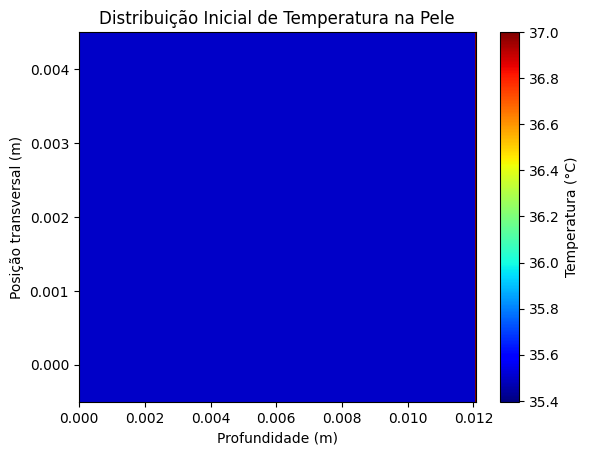

In [ ]:
!pip install ffmpeg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation

# Propriedades biofísicas (legenda: tumor, epidermis, papillary, reticular, subcutaneos, muscle)
ro = np.array([1030, 1200, 1200, 1200, 1000, 1085])  # Densidade [kg/m^3]
c = np.array([3852, 3589, 3300, 3300, 2674, 3800])    # Calor específico [J/(kg.K)]
k = np.array([0.558, 0.235, 0.445, 0.445, 0.185, 0.51])  # Condutividade térmica [W/(m.K)]
#alfa = k / (ro * c)  # Difusividade térmica
omega = np.array([0.0063, 0, 0.0002, 0.0013, 0.0001, 0.0027])  # Perfusão sanguínea
Q_bas = np.array([3700, 0, 368.1, 368.1, 368.3, 684.2])  # Taxa metabólica basal [W/m^3]
q = np.array([1.1, 2, 2, 2, 2, 2])  # Fator de ajuste metabólico

# Defina a ordem das camadas
camadas = [1, 2, 3, 4, 5, 0, 5]  # Ordem: Epidermis, papillary, reticular, subcutanea, muscular, tumor, muscular

# Espessuras das camadas correspondentes [m]
#H_layers = np.array([0.00045, 0.0001, 0.0007, 0.0008, 0.002, 0.004])  # Espessuras em ordem personalizada
H_layers = np.array([0.45, 0.1, 0.7, 0.8, 2, 4])/1000  # Espessuras em ordem personalizada
H_layers = H_layers[np.array(camadas)]  # Reordena as espessuras

# Reorganiza as propriedades com base na ordem das camadas
ro = ro[camadas]
c = c[camadas]
k = k[camadas]
omega = omega[camadas]
Q_bas = Q_bas[camadas]
q = q[camadas]

alfa = k / (ro * c)  # Difusividade térmica

h = 100
rho_b = 1050         # Blood density (kg/m^3)
c_pb = 3600

# Temperaturas fixas
ta = 37  # Temperatura arterial [°C]
te = 20  # Temperatura externa [°C]
t0 = 35.5

# Funções para cálculo de Q e w
def calc_Q(T, Q_bas, q):
    """Cálculo da taxa metabólica ajustada"""
    return Q_bas * q ** ((T - ta) / 10)

def calc_w(T, omega, q):
    """Cálculo da perfusão sanguínea ajustada"""
    return omega * q ** ((T - ta) / 10)

# Calcula os valores iniciais para w e Q
# w = calc_w(ta, omega, q)
# Q = calc_Q(ta, Q_bas, q)

# Configuração para o Método das Diferenças Finitas (FDM)
H_total = np.sum(H_layers)  # Profundidade total [m]
dx = 0.00003  # Passo espacial [m]
num_points_per_layer = (H_layers / dx).astype(int)  # Pontos por camada
num_points = np.sum(num_points_per_layer)  # Total de pontos

dt = 0.5 * (dx**2) / 1.25 * np.max(alfa)  # Passo temporal [s]

# Limitação para evitar problemas de memória
tempo = 500  # Tempo total de simulação [s]
nsteps = min(int(tempo / dt), 10000)  # Número de passos de tempo
tempo = nsteps * dt  # Tempo total de simulação [s]

# Inicialização do array de temperatura
u = t0 * np.ones(num_points)  # Temperatura inicial
u[-1] = ta  # Condição de contorno

# Função para determinar a camada com base no índice do ponto
def identificar_camada(indice, num_points_per_layer):
    acumulado = 0
    for i, pontos in enumerate(num_points_per_layer):
        acumulado += pontos
        if indice < acumulado:
            return i
    return len(num_points_per_layer) - 1

# Criação da grade para visualização
x = np.linspace(0, H_total, num_points)
y = np.linspace(0, 0.004, 5)
x, y = np.meshgrid(x, y)

# Verify alignment
print(f"x.min(): {x.min()}, x.max(): {x.max()}")
print(f"y.min(): {y.min()}, y.max(): {y.max()}")
print(f"u.min(): {u.min()}, u.max(): {u.max()}")

# Criar tensor de temperatura
T = np.tile(u, (5, 1))  # Ajustar para (5, num_points)
T_tensor = T.copy().reshape((5, num_points, 1))

# Criar tensor de tempo
tempo_array = np.linspace(0, tempo, nsteps - 1)
tempo_tensor = tempo_array.copy().reshape((1, 1, nsteps - 1))
tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

# Combinar temperatura e tempo em um mapa temporal
mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)

# Verificar dimensões
print(f"Dimensão de T_tensor: {T_tensor.shape}")
print(f"Dimensão de mapa_temporal: {mapa_temporal.shape}")

#Simulação
for t in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (h * te + ((k[1] / dx) * u0[1])) / (h + (k[1] / dx))

  for i in range(1, num_points - 1):
    m = identificar_camada(i, num_points_per_layer)
    w = calc_w(u0[i], omega[m], q[m])
    Q = calc_Q(u0[i], Q_bas[m], q[m])

    beta = (w * rho_b * c_pb) / (ro[m] * c[m])
    u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + ((alfa[m] * dt)/k[m]) * Q
    #u[i] = u0[i] + dt * (((alfa[m] * (u0[i-1] - 2*u0[i] + u0[i+1])) / (dx**2)) + (beta * (ta - u0[i])) + Q / (ro[m] * c[m]))

  mapa_temporal[:, :, t] = np.tile(u, (5, 1))

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::5]   #200 frames animados
print(f"y: {y.shape}, x: {x.shape}, movie_frames[:, :, 0]: {movie_frames[:, :, 0].shape}")

# Visualização do campo de temperatura inicial
fig, ax = plt.subplots()
pcm = ax.pcolormesh(y, x, movie_frames[:, :, 0], cmap='jet', vmin=np.min(u), vmax=np.max(u), shading = "nearest")
fig.colorbar(pcm, ax=ax, label='Temperatura (°C)')
ax.set_title('Distribuição Inicial de Temperatura na Pele')
plt.xlabel('Profundidade (m)')
plt.ylabel('Posição transversal (m)')

# Seleciona os frames a serem animados
tempo_video = 10000  #[ms]
numero_frames = 200
intervalo_tempo = int(tempo_video / numero_frames)  #[ms]

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('bioheat_skin_cancer_animation.mp4', writer='ffmpeg', fps=20) # Changed to mp4 and specified writer

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()





v3 - experimental

x.min(): 0.0, x.max(): 0.01205
y.min(): 0.0, y.max(): 0.004
u.min(): 35.5, u.max(): 37.0
Dimensão de T_tensor: (5, 399, 1)
Dimensão de mapa_temporal: (5, 399, 100000)
y: (5, 399), x: (5, 399), movie_frames[:, :, 0]: (5, 399)


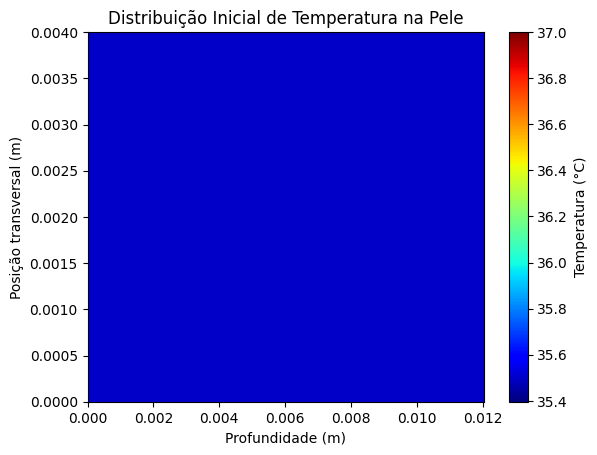

In [3]:
!pip install ffmpeg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation

# Propriedades biofísicas (legenda: tumor, epidermis, papillary, reticular, subcutaneos, muscle)
ro = np.array([1030, 1200, 1200, 1200, 1000, 1085])  # Densidade [kg/m^3]
c = np.array([3852, 3589, 3300, 3300, 2674, 3800])    # Calor específico [J/(kg.K)]
k = np.array([0.558, 0.235, 0.445, 0.445, 0.185, 0.51])  # Condutividade térmica [W/(m.K)]
#alfa = k / (ro * c)  # Difusividade térmica
omega = np.array([0.0063, 0, 0.0002, 0.0013, 0.0001, 0.0027])  # Perfusão sanguínea
Q_bas = np.array([3700, 0, 368.1, 368.1, 368.3, 684.2])  # Taxa metabólica basal [W/m^3]
q = np.array([1.1, 2, 2, 2, 2, 2])  # Fator de ajuste metabólico

# Defina a ordem das camadas
camadas = [1, 2, 3, 4, 5, 0, 5]  # Ordem: Epidermis, papillary, reticular, subcutanea, muscular, tumor, muscular

# Espessuras das camadas correspondentes [m]
#H_layers = np.array([0.00045, 0.0001, 0.0007, 0.0008, 0.002, 0.004])  # Espessuras em ordem personalizada
H_layers = np.array([0.45, 0.1, 0.7, 0.8, 2, 4])/1000  # Espessuras em ordem personalizada
H_layers = H_layers[np.array(camadas)]  # Reordena as espessuras

# Reorganiza as propriedades com base na ordem das camadas
ro = ro[camadas]
c = c[camadas]
k = k[camadas]
omega = omega[camadas]
Q_bas = Q_bas[camadas]
q = q[camadas]

alfa = k / (ro * c)  # Difusividade térmica

h = 100
rho_b = 1050         # Blood density (kg/m^3)
c_pb = 3600

# Temperaturas fixas
ta = 37  # Temperatura arterial [°C]
te = 20  # Temperatura externa [°C]
t0 = 35.5

# Funções para cálculo de Q e w
def calc_Q(T, Q_bas, q):
    """Cálculo da taxa metabólica ajustada"""
    return Q_bas * np.power(q, ((T - ta) / 10))

def calc_w(T, omega, q):
    """Cálculo da perfusão sanguínea ajustada"""
    return omega * np.power(q, ((T - ta) / 10))

# Calcula os valores iniciais para w e Q
# w = calc_w(ta, omega, q)
# Q = calc_Q(ta, Q_bas, q)

# Configuração para o Método das Diferenças Finitas (FDM)
H_total = np.sum(H_layers)  # Profundidade total [m]
dx = 0.00003  # Passo espacial [m]
num_points_per_layer = (H_layers / dx).astype(int)  # Pontos por camada
num_points = np.sum(num_points_per_layer)  # Total de pontos

dt = 0.5 * (dx**2) / 1.25 * np.max(alfa)  # Passo temporal [s]

# Limitação para evitar problemas de memória
tempo = 500  # Tempo total de simulação [s]
nsteps = min(int(tempo / dt), 1000000)  # Número de passos de tempo
tempo = nsteps * dt  # Tempo total de simulação [s]

# Inicialização do array de temperatura
u = t0 * np.ones(num_points)  # Temperatura inicial
u[-1] = ta  # Condição de contorno

# Função para determinar a camada com base no índice do ponto
def identificar_camada(indice, num_points_per_layer):
    acumulado = 0
    for i, pontos in enumerate(num_points_per_layer):
        acumulado += pontos
        if indice < acumulado:
            return i
    return len(num_points_per_layer) - 1

# Criação da grade para visualização
x = np.linspace(0, H_total, num_points)
y = np.linspace(0, 0.004, 5)
x, y = np.meshgrid(x, y)

# Verify alignment
print(f"x.min(): {x.min()}, x.max(): {x.max()}")
print(f"y.min(): {y.min()}, y.max(): {y.max()}")
print(f"u.min(): {u.min()}, u.max(): {u.max()}")

# Criar tensor de temperatura
T = np.tile(u, (5, 1))  # Ajustar para (5, num_points)
T_tensor = T.copy().reshape((5, num_points, 1))

# Criar tensor de tempo
tempo_array = np.linspace(0, tempo, nsteps - 1)
tempo_tensor = tempo_array.copy().reshape((1, 1, nsteps - 1))
tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

# Combinar temperatura e tempo em um mapa temporal
mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)

# Verificar dimensões
print(f"Dimensão de T_tensor: {T_tensor.shape}")
print(f"Dimensão de mapa_temporal: {mapa_temporal.shape}")

#Simulação
for t in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (h * te + ((k[1] / dx) * u0[1])) / (h + (k[1] / dx))

  for i in range(1, num_points - 1):
    m = identificar_camada(i, num_points_per_layer)
    w = calc_w(u0[i], omega[m], q[m])
    Q = calc_Q(u0[i], Q_bas[m], q[m])

    beta = (w * rho_b * c_pb) / (ro[m] * c[m])
    #u[i] = (1 - (2 * alfa[m] *dt / dx**2) - beta * dt) * u0[i] + ((alfa[m] * dt)/(dx**2) * (u0[i+1] - u0[i-1])) + (beta * ta * dt) + (Q*dt)/(ro[m] * c[m])
    u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + ((alfa[m] * dt)/k[m]) * Q
    #u[i] = u0[i] + dt * (((alfa[m] * (u0[i-1] - 2*u0[i] + u0[i+1])) / (dx**2)) + (beta * (ta - u0[i])) + Q / (ro[m] * c[m]))

  mapa_temporal[:, :, t] = np.tile(u, (5, 1))

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::10000]   #100 frames animados
print(f"y: {y.shape}, x: {x.shape}, movie_frames[:, :, 0]: {movie_frames[:, :, 0].shape}")

# Visualização do campo de temperatura inicial
fig, ax = plt.subplots()
im = ax.imshow(movie_frames[:, :, 0], cmap='jet', origin='lower',
               extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', animated=True)
plt.colorbar(im, label='Temperatura (°C)')
plt.title('Distribuição Inicial de Temperatura na Pele')
plt.xlabel('Profundidade (m)')
plt.ylabel('Posição transversal (m)')

# Seleciona os frames a serem animados
tempo_video = 10000  #[ms]
numero_frames = 100
intervalo_tempo = int(tempo_video / numero_frames)  #[ms]

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    im.set_array(movie_frames[:,:,0])
    return [im]

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    im.set_array(movie_frames[:,:,i])
    return [im]

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 100, blit = "True")

#Save the animation as an avi movie file.
anim.save('bioheat_skin_cancer_animation.mp4', writer='ffmpeg', fps=20) # Changed to mp4 and specified writer

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()


